In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, ELU, Sequential, ModuleList
from torch_geometric.nn import GATConv
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import global_mean_pool

from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, heads, nbr_classes):
        super(GAT, self).__init__()
        self.nbr_classes = nbr_classes
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads))
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
        # self.double_mlp = torch.nn.Sequential(torch.nn.Linear(hidden_channels * heads, hidden_channels), torch.nn.ReLU(), torch.nn.Linear(hidden_channels, hidden_channels))
        self.mlp = torch.nn.Sequential(torch.nn.Linear(hidden_channels * heads, hidden_channels), torch.nn.ReLU(), torch.nn.Linear(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        # xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.elu(x)  # Using ELU activation for GAT
            if self.dropout > 0:
                x = F.dropout(x, p=self.dropout, training=self.training)
                # xs.append(x)
        x = global_mean_pool(x, batch)
        # x = torch.cat(xs, dim=1)
        # x = self.double_mlp(x)
        x = self.mlp(x)
        return x

In [3]:
# Some cells from the Graph_Building ipynb because I didn't manage to save the dataset in a way that I could use it in another notebook

from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import from_networkx

import networkx as nx
from networkx.convert_matrix import from_numpy_array

# Creating a dictionary of lists of paths to the correlation matrices for each method. Each list in the dictionary represents a different method.
methods = ['pearson', 'spearman', 'kendall', 'partial']
full_corr_path_lists = {}
for method in methods:
    method_dir = f'ADNI_full/corr_matrices/corr_matrix_{method}/'
    full_corr_path_lists[method] = []
    for file in os.listdir(method_dir):
        full_corr_path_lists[method].append(file)
# Generating the diagnostic file from the diagnostic_label.csv file
diagnostic_label = np.loadtxt('ADNI_full/diagnostic_label.csv', dtype=str, delimiter=',')

# Combining the 'EMCI', 'LMCI' and 'MCI' diagnostics into a single 'MCI' label for simplicity, then one-hot encoding the diagnostics
for patient in range(len(diagnostic_label)):
    if diagnostic_label[patient] == 'CN':
        diagnostic_label[patient] = 0
    elif diagnostic_label[patient] == 'SMC':
        diagnostic_label[patient] = 1
    elif diagnostic_label[patient] == 'EMCI' or diagnostic_label[patient] == 'LMCI' or diagnostic_label[patient] == 'MCI':
        diagnostic_label[patient] = 2
    elif diagnostic_label[patient] == 'AD':
        diagnostic_label[patient] = 3
    else:
        print('Error: Diagnostic label not recognised')
        break

# Loading the age feature of patients to use as a node feature
ages = np.loadtxt('ADNI_full/age.csv', delimiter=',')
min_age = np.min(ages)
max_age = np.max(ages)

# Prepocessing the sex feature of patients to use as a node feature. Here, 0 represents male patients and 1 represents female patients
sex = np.loadtxt('ADNI_full/sex.csv', dtype=str, delimiter=',')
for patient in range(len(sex)):
    if sex[patient] == 'M':
        sex[patient] = 0
    else:
        sex[patient] = 1

# Defining functions to simplify the code in the class Raw_to_Graph.
# To convert a dictionnary into a numpy array
def dict_to_array(dict):
    array = np.array(list(dict.values()))
    return array

# To normalize an array
def normalize_array(array):
    norm_array = (array - np.mean(array)) / np.std(array)
    return norm_array

# Defining a class to preprocess raw data into a format suitable for training Graph Neural Networks (GNNs).
## With the possibility of assigning weight to edges, adding the age feature, sex feature, and matrixe profiling.

class Raw_to_Graph(InMemoryDataset):
    def __init__(self, root, threshold, method, weight=False, age=False, sex=False, matrixprofile=False, transform=None, pre_transform=None):
        self.threshold = threshold
        self.method = method
        self.weight = weight
        self.age = age
        self.sex = sex
        self.matrixprofile = matrixprofile
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    # This function is used to process the raw data into a format suitable for GNNs, by constructing graphs out of the connectivity matrices.
    def process(self):
        graphs=[]
        corr_matrices = full_corr_path_lists[self.method]
        for patient_idx, patient_matrix in enumerate(corr_matrices):
            path = f'ADNI_full/corr_matrices/corr_matrix_{self.method}/{patient_matrix}'
            corr_matrix = pd.read_csv(path, header=None).values
            # Here ROIs stands for Regions of Interest
            nbr_ROIs = corr_matrix.shape[0]
            edge_matrix = np.zeros((nbr_ROIs,nbr_ROIs))
            for j in range(nbr_ROIs):
                for k in range(nbr_ROIs):
                    # Here we are using the absolute value of each element of the correlation matrix, as the corr coeff is in the range [-1,1].
                    if np.abs(corr_matrix[j,k]) < self.threshold:
                        edge_matrix[j,k] = 0
                    else:
                        if self.weight:
                            # Here we assign the absolute value of the correlation coefficient as the edge weight.
                            edge_matrix[j,k] = corr_matrix[j,k]
                        else:
                            # Here we assign 1 as the edge weight, i.e. regardless of the the absolute value of the correlation coefficient.
                            edge_matrix[j,k] = 1

            # Create a NetworkX graph from the edge matrix
            NetworkX_graph = from_numpy_array(edge_matrix)

            # Compute the degree, betweenness centrality, clustering coefficient, local efficiency for each node of the graph and the global efficiency of the graph
            degree_dict = dict(NetworkX_graph.degree())
            between_central_dict = nx.betweenness_centrality(NetworkX_graph)
            cluster_coeff_dict = nx.clustering(NetworkX_graph)
            global_eff = nx.global_efficiency(NetworkX_graph)
            local_eff_dict = {}
            for node in NetworkX_graph.nodes():
                subgraph_neighb = NetworkX_graph.subgraph(NetworkX_graph.neighbors(node))
                if subgraph_neighb.number_of_nodes() > 1:
                    efficiency = nx.global_efficiency(subgraph_neighb)
                else:
                    efficiency = 0.0
                local_eff_dict[node] = efficiency

            # Convert the degree, betweenness centrality, local efficiency, clustering coefficient and ratio of local to global efficiency dictionaries to NumPy arrays then normalize them
            degree_array = dict_to_array(degree_dict)
            degree_array_norm = normalize_array(degree_array)

            between_central_array = dict_to_array(between_central_dict)
            between_central_array_norm = normalize_array(between_central_array)

            local_efficiency_array = dict_to_array(local_eff_dict)
            local_eff_array_norm = normalize_array(local_efficiency_array)

            ratio_local_global_array = dict_to_array(local_eff_dict) / global_eff
            ratio_local_global_array_norm = normalize_array(ratio_local_global_array)

            cluster_coeff_array = dict_to_array(cluster_coeff_dict)
            cluster_coeff_array_norm = normalize_array(cluster_coeff_array)

            # Initializing an array for the graph features
            x_array = np.stack([degree_array_norm, between_central_array_norm, local_eff_array_norm, cluster_coeff_array_norm, ratio_local_global_array_norm], axis=-1)
            x_array = x_array.astype(np.float32)
            # pdb.set_trace()

            if self.age:
                # Extracting the age feature of the patient
                patient_age = ages[patient_idx]
                age_norm = (patient_age - min_age) / (max_age - min_age)
                # Making the age array the same size as the other arrays
                age_array = np.full((nbr_ROIs,), age_norm)
                x_array = np.concatenate((x_array, age_array), axis=-1)
            if self.sex:
                # Extracting the sex feature of the patient
                patient_sex = int(sex[patient_idx])
                # Making the sex array the same size as the other arrays
                sex_array = np.full((nbr_ROIs,), patient_sex)
                x_array = np.concatenate((x_array, sex_array), axis=-1)

            if self.matrixprofile:
                path = f'ADNI_full/matrix_profiles/matrix_profile_{method}/{patient_matrix}'
                with open(path, "rb") as fl:
                  patient_dict = pkl.load(fl)
                # combine dimensions
                features = np.array(patient_dict['mp']).reshape(len(patient_dict['mp']),-1)
                features = features.astype(np.float32)
                x_array = np.concatenate((x_array, features), axis=-1)


            # Concatenate the degree, participation coefficient, betweenness centrality, local efficiency, and ratio of local to global efficiency arrays to form a single feature vector
            x = torch.tensor(x_array, dtype=torch.float)

            # Create a Pytorch Geometric Data object from the NetworkX
            graph_data = from_networkx(NetworkX_graph)
            ## The feature matrix of the graph is the degree, betweenness centrality, local efficiency, clustering coefficient and ratio of local to global efficiency of each node
            graph_data.x = x
            ## The target/output variable that we want to predict is the diagnostic label of the patient
            graph_data.y = float(diagnostic_label[patient_idx])
            graphs.append(graph_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

def dataset_features_and_stats(dataset):
    print()
    print(f'Dataset: {dataset}:')
    print('====================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Weighted: {dataset.weight}')
    print(f'Threshold: {dataset.threshold}')
    print(f'Correlation Method: {dataset.method}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {len(np.unique(diagnostic_label))}')

    # Getting the first graph object in the dataset.
    data = dataset[0]

    print()
    print(data)
    print('=============================================================')

    # Some statistics about the first graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

# Testing the class Raw_to_Graph with one example and saving it
threshold = 0.4
weight = False
age = False
sex = False
matrixprofile = True
in_channels = 5 + int(age) + int(sex) + int(matrixprofile)
method = 'pearson'

root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MP{matrixprofile}'
dataset = Raw_to_Graph(root=root, threshold=threshold, method=method, weight=weight)
dataset_features_and_stats(dataset)


Dataset: Raw_to_Graph(197):
Number of graphs: 197
Weighted: False
Threshold: 0.4
Correlation Method: pearson
Number of features: 5
Number of classes: 4

Data(edge_index=[2, 2124], weight=[2124], x=[116, 5], y='0', num_nodes=116)
Number of nodes: 116
Number of edges: 2124
Average node degree: 18.31
Has isolated nodes: False
Has self-loops: True
Is undirected: True


In [4]:
# Creating the train, validation and test sets
X = dataset
y = dataset.data.y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125, random_state=42)
nbr_classes = len(np.unique(y))

print(f'Number of training graphs: {len(X_train)}')
print(f'Number of validation graphs: {len(X_valid)}')
print(f'Number of test graphs: {len(X_test)}')
print(f'Number of classes: {nbr_classes}')

train_loader = DataLoader(X_train, batch_size=16, shuffle=True)
valid_loader = DataLoader(X_valid, batch_size=len(X_valid), shuffle=True)
test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=False)

Number of training graphs: 137
Number of validation graphs: 20
Number of test graphs: 40
Number of classes: 4


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# The function we are using to compute the accuracy of our model
def quick_accuracy(y_hat, y):
  """
  Args :
    y_hat : logits predicted by model [n, num_classes]
    y : ground trutch labels [n]
  returns :
    average accuracy
  """
  n = y.shape[0]
  y_hat = torch.argmax(y_hat, dim=-1)
  accuracy = (y_hat==y).sum().data.item()
  return accuracy/n

In [9]:
# Training the model
def train(model, optimizer, criterion, train_loader, valid_loader, parameters, test_loader=False, testing=False, n_epochs=100):
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_accuracy = 0
        for data in train_loader:
            # Converting each element of data.y to a float
            target = torch.tensor(data.y, dtype=torch.long)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            train_loss += criterion(out, target)
            train_accuracy += quick_accuracy(out, target)

        train_losses.append(train_loss.detach().numpy()/len(train_loader))
        train_accuracies.append(train_accuracy/len(train_loader))

        model.eval()
        valid_loss = 0
        valid_accuracy = 0
        with torch.no_grad():
            for data in valid_loader:
                # Converting each element of data.y to a float
                target = torch.tensor(data.y, dtype=torch.long)
                out = model(data.x, data.edge_index, data.batch)
                valid_loss += criterion(out, target)
                valid_accuracy += quick_accuracy(out, target)

            valid_losses.append(valid_loss.detach().numpy()/len(valid_loader))
            valid_accuracies.append(valid_accuracy/len(valid_loader))

            if testing:
                test_loss = 0
                test_accuracy = 0
                for data in test_loader:
                    # Converting each element of data.y to a long
                    target = torch.tensor(data.y, dtype=torch.long)
                    out = model(data.x, data.edge_index, data.batch)
                    test_loss += criterion(out, target)
                    test_accuracy += quick_accuracy(out, target)

                test_losses.append(test_loss.detach().numpy()/len(test_loader.dataset))
                test_accuracies.append(test_accuracy/len(test_loader.dataset))

        if testing:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
            print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')
        else:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}')
            print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {valid_accuracies[-1]:.4f}')
    
    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    if testing:
        plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Accuracy')
    plt.plot(valid_accuracies, label=f'Validation Accuracy')
    if testing:
        plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Save the plot
    lr = parameters[0]
    hidden_channels = parameters[1]
    num_layers = parameters[2]
    dropout = parameters[3]
    heads = parameters[4]
    if matrixprofile:
        filename = f'GAT_Models_MP/lr{lr}_hc{hidden_channels}_nl{num_layers}_d{dropout}_epochs{n_epochs}_heads{heads}.png'
    else:
        filename = f'GAT_Models/lr{lr}_hc{hidden_channels}_nl{num_layers}_d{dropout}_epochs{n_epochs}_heads{heads}.png'
    plt.savefig(filename)
    plt.show()

    if testing:
        return train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies
    else:
        return train_losses, train_accuracies, valid_losses, valid_accuracies

GAT(
  (convs): ModuleList(
    (0): GATConv(5, 32, heads=2)
    (1-2): 2 x GATConv(64, 32, heads=2)
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)
Epoch 1/1000
Train Loss: 1.3718, Validation Loss: 1.3648
Train Accuracy: 0.4992, Validation Accuracy: 0.5500
Epoch 2/1000
Train Loss: 1.3715, Validation Loss: 1.3643
Train Accuracy: 0.4992, Validation Accuracy: 0.5500
Epoch 3/1000
Train Loss: 1.3694, Validation Loss: 1.3638
Train Accuracy: 0.5100, Validation Accuracy: 0.5500
Epoch 4/1000
Train Loss: 1.3701, Validation Loss: 1.3633
Train Accuracy: 0.4938, Validation Accuracy: 0.5500
Epoch 5/1000
Train Loss: 1.3705, Validation Loss: 1.3628
Train Accuracy: 0.4992, Validation Accuracy: 0.5500
Epoch 6/1000
Train Loss: 1.3688, Validation Loss: 1.3623
Train Accuracy: 0.5046, Validation Accuracy: 0.5500
Epoch 7/1000
Train Loss: 1.3687, Validation Loss: 1.3618
Train Accuracy: 0.4992

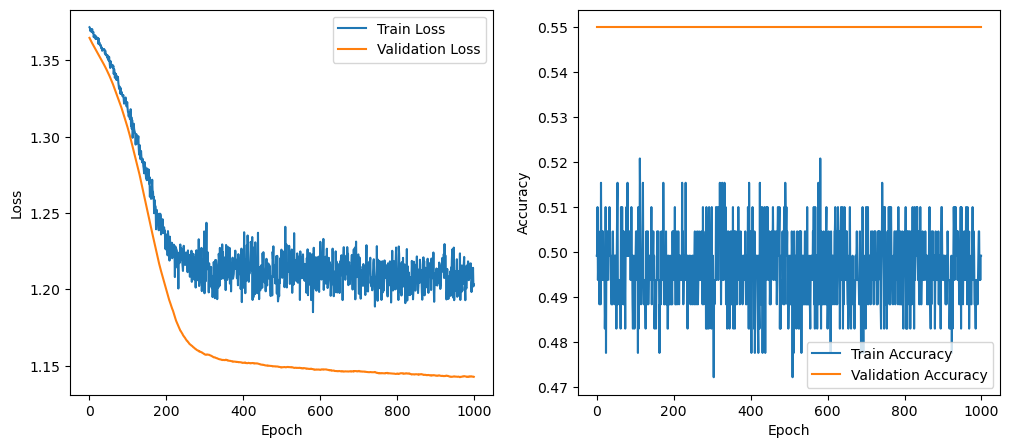

In [8]:
# Defining the model, optimizer and loss function
lr=0.00001
hidden_channels=32
dropout=0.2
num_layers=3
heads=2
parameters = [lr, hidden_channels, num_layers, dropout, heads]

model = GAT(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], heads=parameters[4], nbr_classes=nbr_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0])
criterion = torch.nn.CrossEntropyLoss()

# Printing the model architecture
print(model)

# Running the training
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, optimizer, criterion, train_loader, valid_loader, parameters, n_epochs=1000)

Epoch 1/500
Train Loss: 1.4190, Validation Loss: 1.4129
Train Accuracy: 0.1690, Validation Accuracy: 0.3000
Epoch 2/500
Train Loss: 1.4208, Validation Loss: 1.4129
Train Accuracy: 0.1582, Validation Accuracy: 0.3000
Epoch 3/500
Train Loss: 1.4187, Validation Loss: 1.4128
Train Accuracy: 0.1690, Validation Accuracy: 0.3000
Epoch 4/500
Train Loss: 1.4221, Validation Loss: 1.4128
Train Accuracy: 0.1636, Validation Accuracy: 0.3000
Epoch 5/500
Train Loss: 1.4210, Validation Loss: 1.4127
Train Accuracy: 0.1690, Validation Accuracy: 0.3000
Epoch 6/500
Train Loss: 1.4233, Validation Loss: 1.4127
Train Accuracy: 0.1582, Validation Accuracy: 0.3000
Epoch 7/500
Train Loss: 1.4216, Validation Loss: 1.4126
Train Accuracy: 0.1582, Validation Accuracy: 0.3000
Epoch 8/500
Train Loss: 1.4217, Validation Loss: 1.4126
Train Accuracy: 0.1528, Validation Accuracy: 0.3000
Epoch 9/500
Train Loss: 1.4230, Validation Loss: 1.4125
Train Accuracy: 0.1582, Validation Accuracy: 0.3000
Epoch 10/500
Train Loss: 1.4

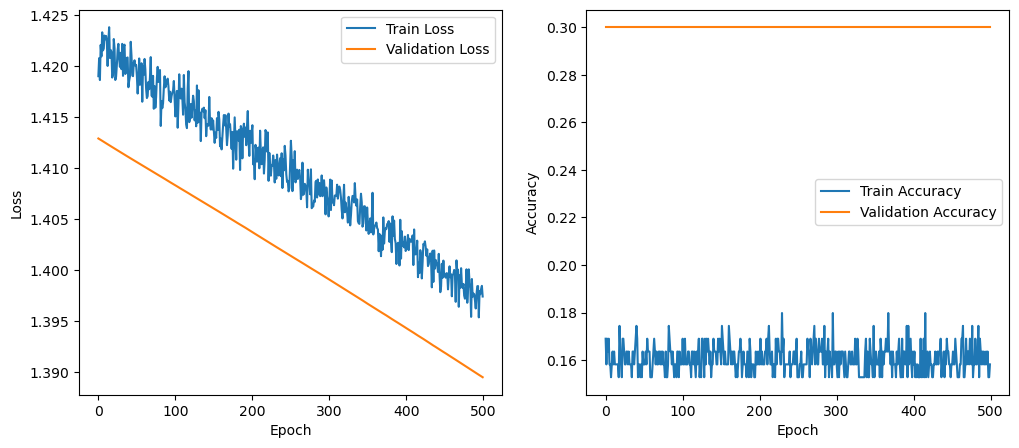

Epoch 1/500
Train Loss: 1.4202, Validation Loss: 1.4620
Train Accuracy: 0.1042, Validation Accuracy: 0.0500
Epoch 2/500
Train Loss: 1.4198, Validation Loss: 1.4619
Train Accuracy: 0.1042, Validation Accuracy: 0.0500
Epoch 3/500
Train Loss: 1.4165, Validation Loss: 1.4618
Train Accuracy: 0.1096, Validation Accuracy: 0.0500
Epoch 4/500
Train Loss: 1.4195, Validation Loss: 1.4618
Train Accuracy: 0.1096, Validation Accuracy: 0.0500
Epoch 5/500
Train Loss: 1.4204, Validation Loss: 1.4617
Train Accuracy: 0.1096, Validation Accuracy: 0.0500
Epoch 6/500
Train Loss: 1.4200, Validation Loss: 1.4617
Train Accuracy: 0.1042, Validation Accuracy: 0.0500
Epoch 7/500
Train Loss: 1.4172, Validation Loss: 1.4616
Train Accuracy: 0.1096, Validation Accuracy: 0.0500
Epoch 8/500
Train Loss: 1.4177, Validation Loss: 1.4615
Train Accuracy: 0.1042, Validation Accuracy: 0.0500
Epoch 9/500
Train Loss: 1.4160, Validation Loss: 1.4615
Train Accuracy: 0.1096, Validation Accuracy: 0.0500
Epoch 10/500
Train Loss: 1.4

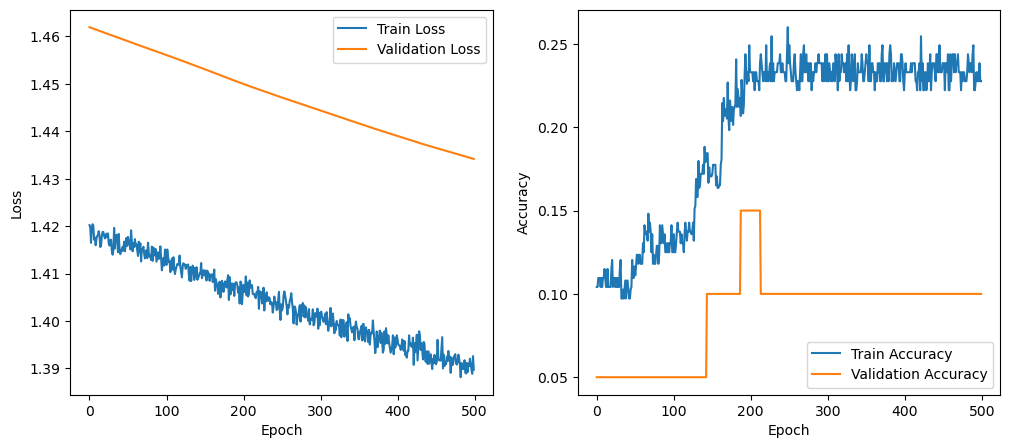

Epoch 1/500
Train Loss: 1.3920, Validation Loss: 1.3857
Train Accuracy: 0.0833, Validation Accuracy: 0.2000
Epoch 2/500
Train Loss: 1.3918, Validation Loss: 1.3856
Train Accuracy: 0.0833, Validation Accuracy: 0.2000
Epoch 3/500
Train Loss: 1.3918, Validation Loss: 1.3856
Train Accuracy: 0.0833, Validation Accuracy: 0.2000
Epoch 4/500
Train Loss: 1.3924, Validation Loss: 1.3855
Train Accuracy: 0.0941, Validation Accuracy: 0.2000
Epoch 5/500
Train Loss: 1.3920, Validation Loss: 1.3854
Train Accuracy: 0.0833, Validation Accuracy: 0.2000
Epoch 6/500
Train Loss: 1.3913, Validation Loss: 1.3853
Train Accuracy: 0.0995, Validation Accuracy: 0.2000
Epoch 7/500
Train Loss: 1.3920, Validation Loss: 1.3853
Train Accuracy: 0.0887, Validation Accuracy: 0.2000
Epoch 8/500
Train Loss: 1.3914, Validation Loss: 1.3852
Train Accuracy: 0.0833, Validation Accuracy: 0.2000
Epoch 9/500
Train Loss: 1.3915, Validation Loss: 1.3851
Train Accuracy: 0.0833, Validation Accuracy: 0.2000
Epoch 10/500
Train Loss: 1.3

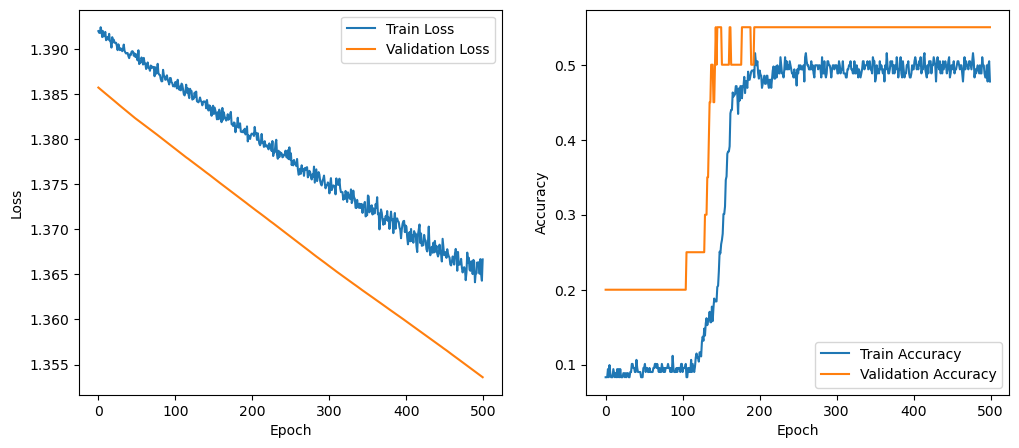

Epoch 1/500
Train Loss: 1.4459, Validation Loss: 1.4311
Train Accuracy: 0.1744, Validation Accuracy: 0.3000
Epoch 2/500
Train Loss: 1.4505, Validation Loss: 1.4308
Train Accuracy: 0.1582, Validation Accuracy: 0.3000
Epoch 3/500
Train Loss: 1.4474, Validation Loss: 1.4305
Train Accuracy: 0.1636, Validation Accuracy: 0.3000
Epoch 4/500
Train Loss: 1.4493, Validation Loss: 1.4302
Train Accuracy: 0.1582, Validation Accuracy: 0.3000
Epoch 5/500
Train Loss: 1.4484, Validation Loss: 1.4299
Train Accuracy: 0.1582, Validation Accuracy: 0.3000
Epoch 6/500
Train Loss: 1.4444, Validation Loss: 1.4296
Train Accuracy: 0.1690, Validation Accuracy: 0.3000
Epoch 7/500
Train Loss: 1.4470, Validation Loss: 1.4293
Train Accuracy: 0.1582, Validation Accuracy: 0.3000
Epoch 8/500
Train Loss: 1.4499, Validation Loss: 1.4291
Train Accuracy: 0.1528, Validation Accuracy: 0.3000
Epoch 9/500
Train Loss: 1.4467, Validation Loss: 1.4288
Train Accuracy: 0.1636, Validation Accuracy: 0.3000
Epoch 10/500
Train Loss: 1.4

KeyboardInterrupt: 

In [11]:
# Doing some parameter gridsearch to find the best hyperparameters
from sklearn.model_selection import ParameterGrid

MP = True

# param_grid = {
#     'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
#     'hidden_channels': [128, 64, 32],
#     'num_layers': [3, 2, 1],
#     'dropout_rate': [0.3, 0.2, 0.1, 0.0],
#     'heads': [5, 4, 3, 2]
# }
param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01],
    'hidden_channels': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'heads': [2, 3, 4, 5]
}

# Create combinations of hyperparameters
param_combinations = ParameterGrid(param_grid)
n_epochs = 500
# Train using each combination
for params in param_combinations:
    if MP:
        filename = f'GAT_Models_MP/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_heads{params["heads"]}.png'
    else:
        filename = f'GAT_Models/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_heads{params["heads"]}.png'
    if os.path.exists(filename):
        pass
    else:
        parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate'], params['heads']]
        model = GAT(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], heads=parameters[4], nbr_classes=nbr_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0])
        criterion = torch.nn.CrossEntropyLoss()
        train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, optimizer, criterion, train_loader, valid_loader, parameters, n_epochs=n_epochs)

